In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(1000, 10)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Current_Market_Stoploss,Rec1,Rec1_P,Rec2,Rec2_P,Rec3,Rec3_P
0,7471.0,7.0,Bearish,0.0,50.0,BUY,97.0,SELL,64.0,BUY
1,2266.0,8.0,Bearish,0.0,51.0,SELL,66.0,BUY,99.0,SELL
2,3273.0,81.0,Bullish,0.0,67.0,BUY,60.0,BUY,8.0,SELL
3,6415.0,75.0,Bearish,0.0,63.0,BUY,91.0,BUY,22.0,SELL
4,7960.0,26.0,Bullish,0.0,42.0,BUY,14.0,BUY,72.0,SELL


## One-Hot Encoding

In [4]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_P'] = dataset['Rec1_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_P'] = dataset['Rec2_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_P'] = dataset['Rec3_P'].replace(['BUY','SELL'],[1,-1])

In [5]:
dataset['Rec1'] = dataset['Rec1'] * dataset['Rec1_P']
dataset['Rec2'] = dataset['Rec2'] * dataset['Rec2_P']
dataset['Rec3'] = dataset['Rec3'] * dataset['Rec3_P']

In [6]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Current_Market_Stoploss',
#    'Rec1',
    'Rec1_P',
#    'Rec2',
    'Rec2_P',
#    'Rec3',
    'Rec3_P'
], axis=1)

In [7]:
dataset.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,50.0,-97.0,64.0
1,0,-51.0,66.0,-99.0
2,1,67.0,60.0,-8.0
3,0,63.0,91.0,-22.0
4,1,42.0,14.0,-72.0


In [8]:
data = dataset.sample(frac=0.80, random_state=810).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (800, 4)
Unseen Data For Predictions: (200, 4)


In [9]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,-66.0,-90.0,72.0
1,1,97.0,-13.0,88.0
2,0,99.0,87.0,-63.0
3,1,-13.0,74.0,-59.0
4,1,84.0,80.0,-97.0


# Create Unseen DataFrame

In [10]:
#data_unseen = pd.DataFrame ({'Rec1': [-60.0], 'Rec2': [64.0], 'Rec3':[1.0]})

In [11]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,-66.0,-90.0,72.0
1,1,97.0,-13.0,88.0
2,0,99.0,87.0,-63.0
3,1,-13.0,74.0,-59.0
4,1,84.0,80.0,-97.0


In [12]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(800, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5529,0.5615,0.5603,0.5469,0.5513,0.1068,0.1078,0.0140
lightgbm,Light Gradient Boosting Machine,0.5384,0.5401,0.5161,0.5280,0.5197,0.0761,0.0763,0.0110
rf,Random Forest Classifier,0.5313,0.5594,0.5160,0.5225,0.5170,0.0625,0.0631,0.0480
et,Extra Trees Classifier,0.5278,0.5538,0.4988,0.5221,0.5080,0.0551,0.0556,0.0410
dt,Decision Tree Classifier,0.5081,0.5078,0.4803,0.5008,0.4880,0.0158,0.0155,0.1180
ada,Ada Boost Classifier,0.5080,0.5077,0.5198,0.5001,0.5076,0.0176,0.0178,0.0150
svm,SVM - Linear Kernel,0.4972,0.0000,0.4901,0.4908,0.4887,-0.0059,-0.0055,0.0060
lr,Logistic Regression,0.4956,0.4879,0.4111,0.4837,0.4401,-0.0116,-0.0117,0.2070
ridge,Ridge Classifier,0.4956,0.0000,0.4111,0.4837,0.4401,-0.0116,-0.0117,0.0040
lda,Linear Discriminant Analysis,0.4956,0.4879,0.4111,0.4837,0.4401,-0.0116,-0.0117,0.0030


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

stop

In [14]:
MODEL = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5179,0.5083,0.5556,0.5000,0.5263,0.0382,0.0384
1,0.5536,0.6041,0.5185,0.5385,0.5283,0.1049,0.1049
2,0.5357,0.4777,0.5556,0.5172,0.5357,0.0726,0.0728
3,0.5893,0.5172,0.5556,0.5769,0.5660,0.1765,0.1766
4,0.5357,0.5319,0.5000,0.5385,0.5185,0.0714,0.0716
5,0.6250,0.6288,0.6429,0.6207,0.6316,0.2500,0.2502
6,0.4643,0.4770,0.3929,0.4583,0.4231,-0.0714,-0.0722
7,0.4821,0.5230,0.4286,0.4800,0.4528,-0.0357,-0.0359
8,0.5893,0.6110,0.6786,0.5758,0.6230,0.1786,0.1815
9,0.4909,0.5225,0.3333,0.4737,0.3913,-0.0239,-0.0250


In [15]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5714,0.5734,0.5926,0.5517,0.5714,0.1439,0.1443
1,0.5357,0.5990,0.6296,0.5152,0.5667,0.0773,0.0791
2,0.4286,0.3934,0.4074,0.4074,0.4074,-0.1443,-0.1443
3,0.5357,0.5364,0.4074,0.5238,0.4583,0.0631,0.0646
4,0.4643,0.5140,0.4286,0.4615,0.4444,-0.0714,-0.0716
5,0.5357,0.5957,0.6429,0.5294,0.5806,0.0714,0.0731
6,0.5714,0.5816,0.5357,0.5769,0.5556,0.1429,0.1432
7,0.5179,0.5510,0.5000,0.5185,0.5091,0.0357,0.0357
8,0.5714,0.6301,0.5357,0.5769,0.5556,0.1429,0.1432
9,0.6182,0.6323,0.5185,0.6364,0.5714,0.2336,0.2376


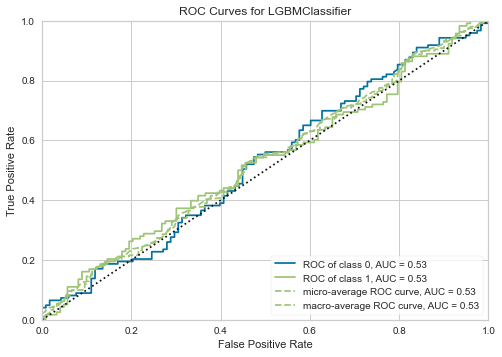

In [16]:
plot_model(TUNED_MODEL, plot = 'auc')

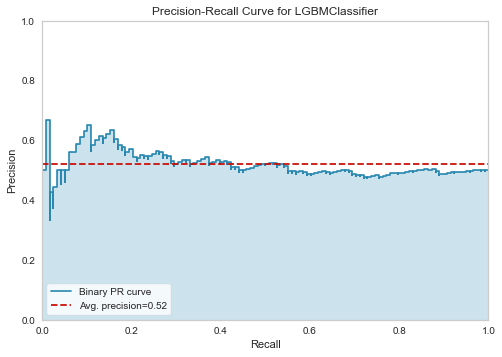

In [17]:
plot_model(TUNED_MODEL, plot = 'pr')

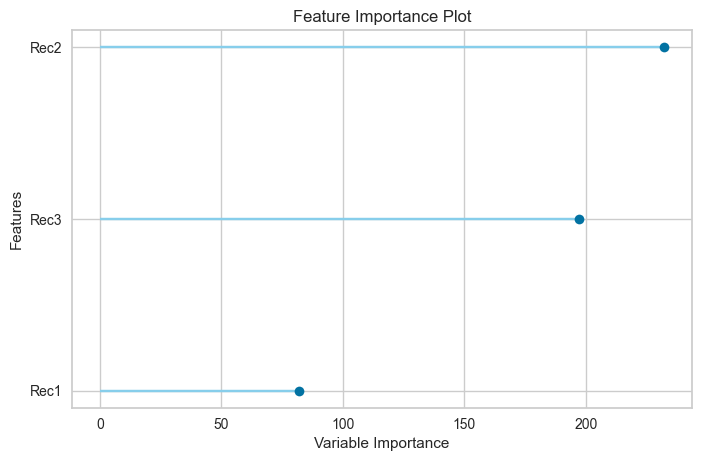

In [18]:
plot_model(TUNED_MODEL, plot='feature')

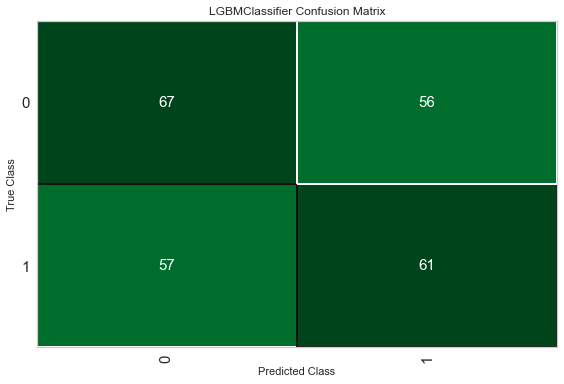

In [19]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [20]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5311,0.5253,0.5169,0.5214,0.5191,0.0617,0.0617


In [21]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [22]:
print(FINAL_MODEL)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [23]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9253,0.9876,0.9153,0.9310,0.9231,0.8505,0.8506


In [24]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,-66.0,-90.0,72.0,0,0.9852
1,1,97.0,-13.0,88.0,1,0.7022
2,0,99.0,87.0,-63.0,0,0.6485
3,1,-13.0,74.0,-59.0,1,0.7823
4,1,84.0,80.0,-97.0,1,0.9499


In [25]:
save_model(FINAL_MODEL,'Final_Model_LIGHTGBM_16Nov2021_EURUSD_1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
             

In [26]:
SAVED_FINAL_MODEL = load_model('Final_Model_LIGHTGBM_16Nov2021_EURUSD_1')

Transformation Pipeline and Model Successfully Loaded


In [27]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [28]:
new_prediction.head(20)

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,-66.0,-90.0,72.0,0,0.9852
1,1,97.0,-13.0,88.0,1,0.7022
2,0,99.0,87.0,-63.0,0,0.6485
3,1,-13.0,74.0,-59.0,1,0.7823
4,1,84.0,80.0,-97.0,1,0.9499
5,0,-98.0,4.0,-81.0,0,0.7884
6,1,-73.0,-55.0,-83.0,1,0.6268
7,1,-98.0,-77.0,-50.0,1,0.6906
8,1,-59.0,80.0,81.0,1,0.9027
9,1,7.0,-3.0,78.0,1,0.9438


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b